# PPProjecct

In [ ]:
!pip install probaforms -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 46.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.1 

## Data

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv('train_cache.csv')
train.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,712511,386627.74,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
1,709311,388112.33,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
2,712464,386384.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
3,711226,387053.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
4,710919,387191.78,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769


In [ ]:
test = pd.read_csv('test_cache.csv')
test.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,21483,613944.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
1,21354,610190.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
2,20883,613910.75,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
3,21493,610052.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
4,21473,606866.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065


In [ ]:
pd.unique(train[['block_size']]. values.ravel())

array([  8,  16,  32,  64, 256,   4, 128])

In [ ]:
pd.unique(train[['n_jobs']]. values.ravel()).size

32

In [ ]:
pd.unique(train[['iodepth']]. values.ravel()).size

16

In [ ]:
pd.unique(train[['read_fraction']]. values.ravel()).size

101

In [ ]:
pd.unique(train[['io_type']]. values.ravel())

array(['read', 'write'], dtype=object)

In [ ]:
pd.unique(train[['id']]. values.ravel()).size

408

In [ ]:
test['id'] = test['id'] + '-' + test['io_type']

In [ ]:
test['io_type_num'] = test['io_type'] == 'write'

In [ ]:
test.io_type_num = test.io_type_num.replace({ True : 1 , False : 0 })

In [ ]:
y_test = torch.tensor(test[['iops', 'lat']].values)

In [ ]:
X_test = torch.tensor(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
print(len(y_test), len(X_test))

12120 12120


In [ ]:
train['id'] = train['id'] + '-' + train['io_type']

In [ ]:
train['io_type_num'] = train['io_type'] == 'write'

In [ ]:
train.io_type_num = train.io_type_num.replace({ True : 1 , False : 0 })

In [ ]:
y_tr = torch.tensor(train[['iops', 'lat']].values)

In [ ]:
X_tr = torch.tensor(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
pd.unique(train[['id']]. values.ravel())

array(['hse-09142022-013313-z3769-read',
       'hse-09132022-220621-z47654-read',
       'hse-09132022-220621-z47654-write',
       'hse-09132022-145656-z44664-read',
       'hse-09132022-145656-z44664-write',
       'hse-09132022-114106-z26207-read',
       'hse-09132022-114106-z26207-write',
       'hse-09132022-193036-z66798-read',
       'hse-09132022-193036-z66798-write',
       'hse-09132022-144055-z72468-read',
       'hse-09132022-144055-z72468-write',
       'hse-09132022-204254-z78794-read',
       'hse-09132022-204254-z78794-write',
       'hse-09132022-225919-z97534-read',
       'hse-09132022-225919-z97534-write',
       'hse-09132022-231343-z49201-read',
       'hse-09132022-231343-z49201-write',
       'hse-09142022-005311-z97289-read',
       'hse-09142022-005311-z97289-write',
       'hse-09132022-181650-z73563-read',
       'hse-09132022-181650-z73563-write',
       'hse-09132022-183252-z8604-read',
       'hse-09132022-183252-z8604-write',
       'hse-09132022-23120

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065-read',
       'hse-09132022-180712-z63065-write',
       'hse-09132022-212616-z36709-read',
       'hse-09132022-212616-z36709-write',
       'hse-09132022-203942-z36542-read',
       'hse-09132022-203942-z36542-write',
       'hse-09132022-113615-z47578-read',
       'hse-09132022-113615-z47578-write',
       'hse-09132022-113127-z92275-read',
       'hse-09132022-113127-z92275-write',
       'hse-09132022-202959-z97080-read',
       'hse-09132022-202959-z97080-write',
       'hse-09132022-130756-z72964-read',
       'hse-09132022-130756-z72964-write',
       'hse-09132022-152621-z23474-read',
       'hse-09132022-152621-z23474-write',
       'hse-09132022-222402-z67880-read',
       'hse-09132022-222402-z67880-write',
       'hse-09142022-002727-z41754-read',
       'hse-09142022-002727-z41754-write',
       'hse-09132022-215503-z42747-read',
       'hse-09132022-215503-z42747-write',
       'hse-09132022-154850-z69269-read',
       'hse-09132022-15

In [ ]:
# id + "read" or "write" done

## Outliers

using z-score

In [ ]:
new_train = pd.DataFrame()

In [ ]:
from scipy import stats

In [ ]:
for idd in pd.unique(train[['id']]. values.ravel()):
    arr = train[train['id'] == idd]
    z = stats.zscore(arr[['iops', 'lat']])
    z_mask = (np.abs(z) < 3).all(axis = 1)
    arr_z = arr[z_mask]
    new_train = pd.concat([new_train, arr_z], ignore_index=True)

In [ ]:
print(len(train))
print(len(new_train))

48480
47458


In [ ]:
new_test = pd.DataFrame()

In [ ]:
for idd in pd.unique(test[['id']]. values.ravel()):
    arr = test[test['id'] == idd]
    z = stats.zscore(arr[['iops', 'lat']])
    z_mask = (np.abs(z) < 3).all(axis = 1)
    arr_z = arr[z_mask]
    new_test = pd.concat([new_test, arr_z], ignore_index=True)

In [ ]:
print(len(test))
print(len(new_test))

12120
11867


In [ ]:
new_train.isnull().any().any()

False

In [ ]:
new_test.isnull().any().any()

False

## Scalers

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
from dataclasses import dataclass

# from https://github.com/HEPML-AnomalyDetection/CATHODE/blob/4e96989296193da18508710afbfa3b37fffe5952/data_handler.py
def logit_transform_inverse(data, datamin, datamax):
    dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))
    return dataout

def quick_logit(x, x_min, x_max, eps):
    x_norm = (x-x_min)/(x_max-x_min)
    x_norm = x_norm[((x_norm != 0) & (x_norm != 1)).all(axis=1)]
    x_norm[x_norm == 0] += eps
    x_norm[x_norm == 1] -= eps
    logit = np.log(x_norm/(1-x_norm))
    logit = logit[~np.isnan(logit).any(axis=1)]
    return logit

class LogitScaler(TransformerMixin, BaseEstimator):

    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.x_max = None
        self.x_min = None

    def fit(self, X, y=None):
        self.x_min = np.min(X, axis=0) - self.eps
        self.x_max = np.max(X, axis=0) + self.eps
        return self

    def transform(self, X):
        return quick_logit(X, self.x_min, self.x_max, self.eps)

    def inverse_transform(self, X):
        return logit_transform_inverse(X, self.x_min, self.x_max)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.1), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-34-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

## Graphs

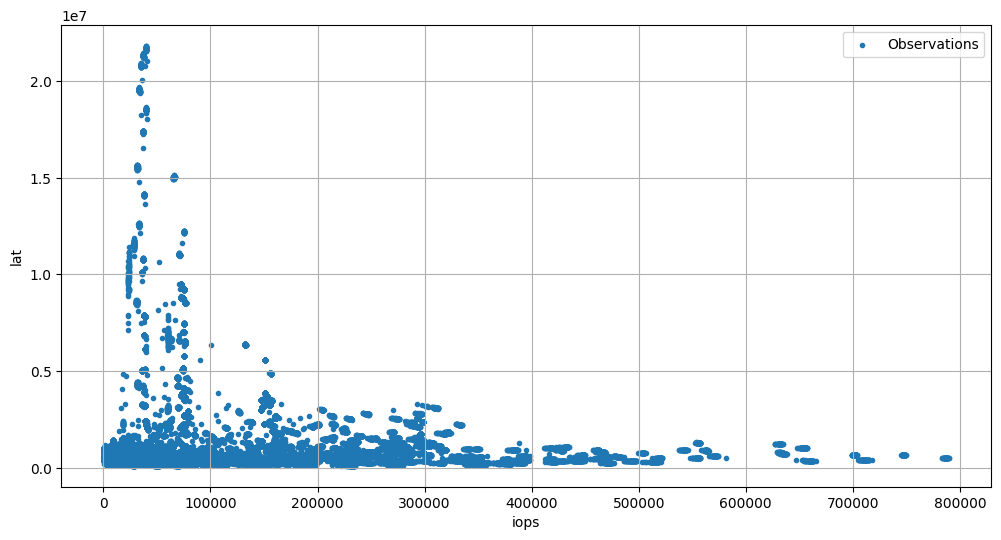

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_tr[:, 0], y_tr[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

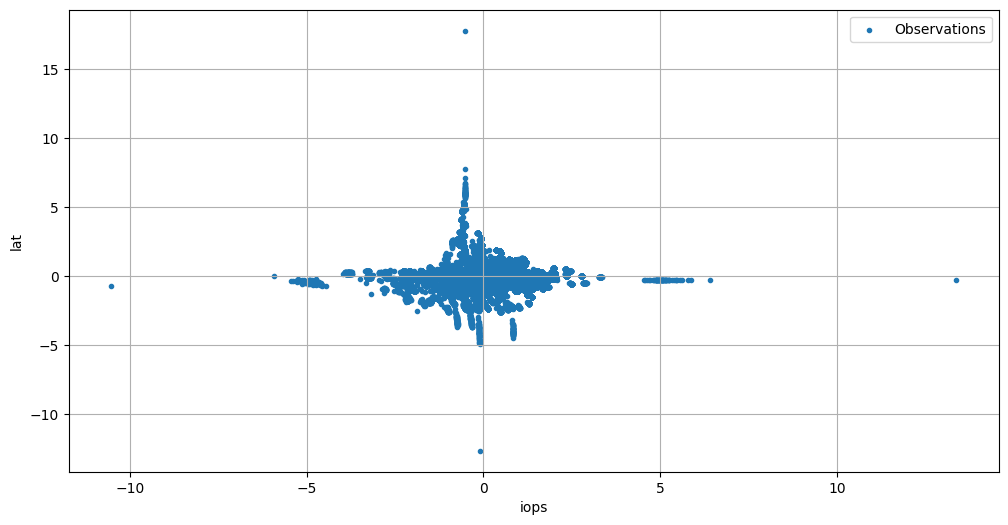

In [ ]:
scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
y_tr_ss = torch.tensor(scaler.fit_transform(train[['iops', 'lat']].values))

plt.figure(figsize=(12, 6))
plt.scatter(y_tr_ss[:, 0], y_tr_ss[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

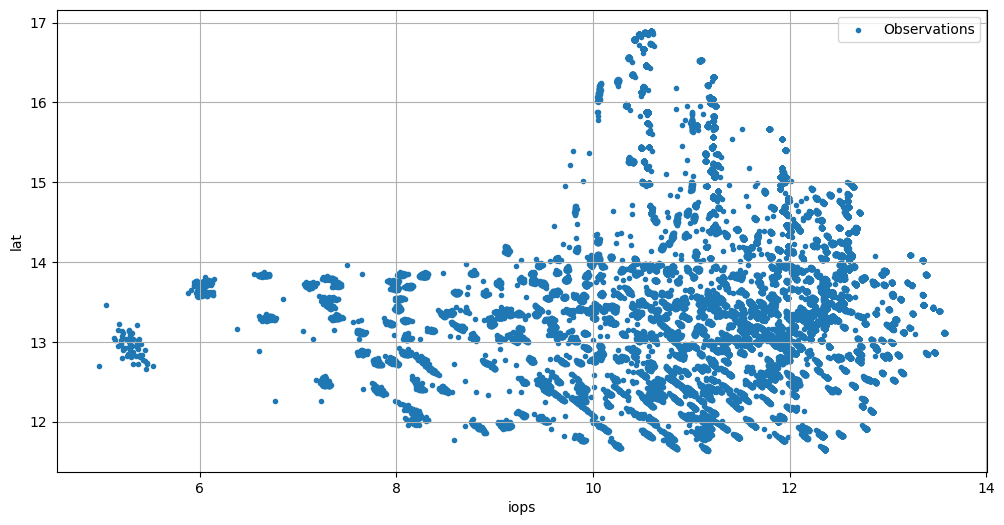

In [ ]:
y_tr_ss = torch.tensor(np.log(train[['iops', 'lat']].values))

plt.figure(figsize=(12, 6))
plt.scatter(y_tr_ss[:, 0], y_tr_ss[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Graphs without outliers

In [ ]:
y_tr_w = torch.tensor(new_train[['iops', 'lat']].values)

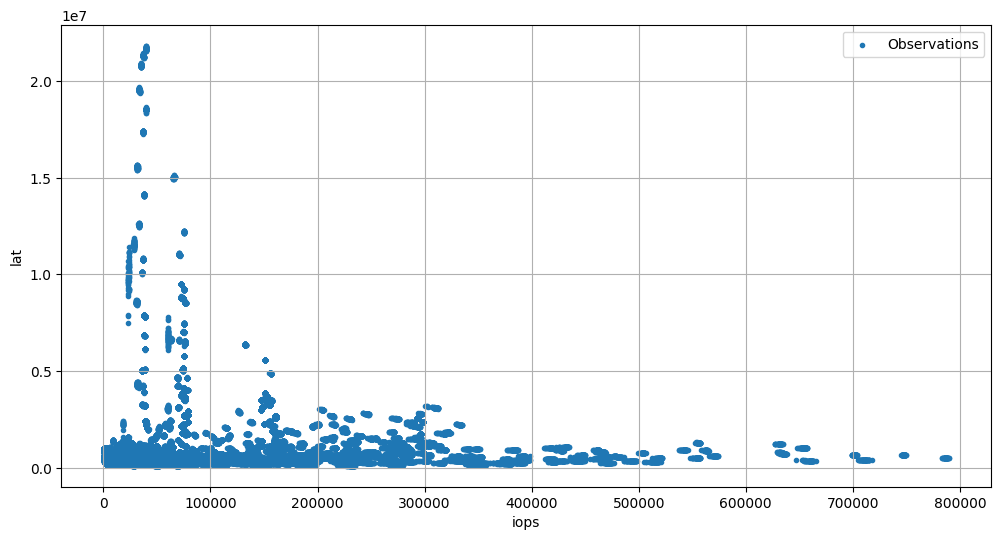

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_tr_w[:, 0], y_tr_w[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

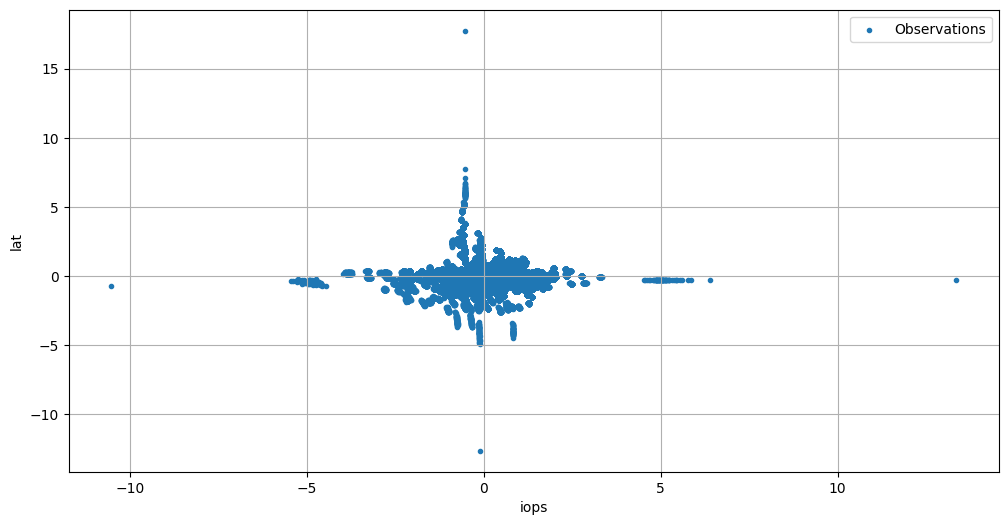

In [ ]:
scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
y_tr_ss = torch.tensor(scaler.fit_transform(new_train[['iops', 'lat']].values))

plt.figure(figsize=(12, 6))
plt.scatter(y_tr_ss[:, 0], y_tr_ss[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

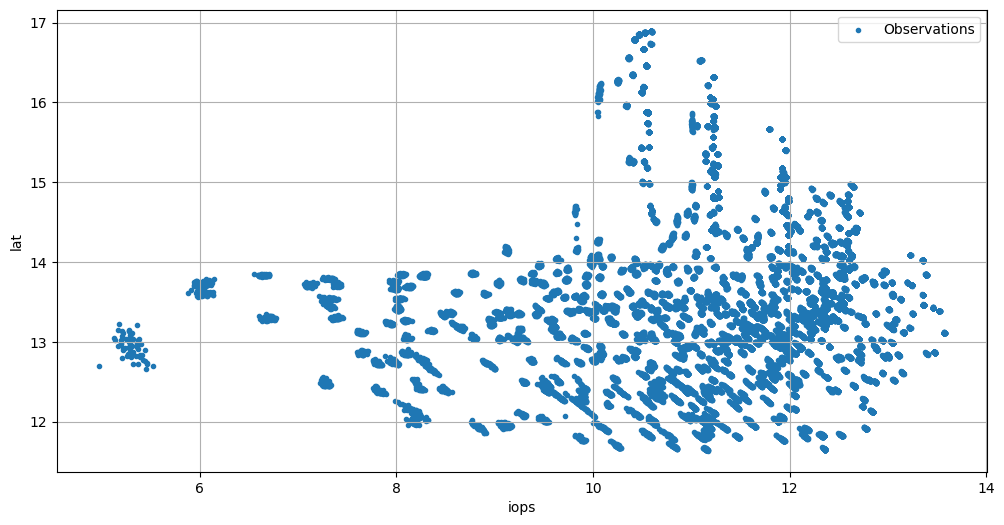

In [ ]:
y_tr_ss = torch.tensor(np.log(new_train[['iops', 'lat']].values))

plt.figure(figsize=(12, 6))
plt.scatter(y_tr_ss[:, 0], y_tr_ss[:, 1], marker='.', label='Observations', linewidth=1)
# оси
plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Final experiments

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from probaforms.models import RealNVP
from probaforms import metrics

In [ ]:
train = train
scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
# y_test_ss = scaler.transform(test[['iops', 'lat']].values)
stscaler = StandardScaler()
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
# X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

model = RealNVP(lr=0.001, n_layers=12, n_epochs=100, batch_size=64, hidden=(100,)) # 200 , hidden=(100,), activation='relu'
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

In [ ]:
def calc_metrics(X, Y):
    mu, sigma = metrics.frechet_distance(X, Y)
    print(r"Frechet Distance         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.kolmogorov_smirnov_1d(X, Y)
    print(r"Kolmogorov-Smirnov       = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.cramer_von_mises_1d(X, Y)
    print(r"Cramer-von Mises         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.anderson_darling_1d(X, Y)
    print(r"Anderson-Darling         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.roc_auc_score_1d(X, Y)
    print(r"ROC AUC                  = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.kullback_leibler_1d_kde(X, Y)
    print(r"Kullback-Leibler KDE     = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.jensen_shannon_1d_kde(X, Y)
    print(r"Jensen-Shannon KDE       = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.maximum_mean_discrepancy(X, Y)
    print(r"Maximum Mean Discrepancy = %.4f +- %.4f" % (mu, sigma))

### RESULTS (TRAIN)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
ids = ['hse-09132022-234723-z24647-read', 'hse-09132022-155203-z5570-read',
       'hse-09132022-234723-z24647-write', 'hse-09132022-155203-z5570-write']
ztotal_iops = []
ztotal_lat = []
zgen_iops = []
zgen_lat = []

total_iops = []
total_lat = []
gen_iops = []
gen_lat = []
for i in range(len(ids)):
    y_train = torch.tensor(train[train['id'] == ids[i]][['iops', 'lat']].values)
    total_iops.append(y_train[:, 0])
    total_lat.append(y_train[:, 1])
    X_train = torch.tensor(train[train['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
    y_train_ss = scaler.transform(y_train)
    X_train_ss = stscaler.transform(X_train)
    y_tst = torch.tensor(y_train_ss, dtype=torch.float32)
    X_tst = torch.tensor(X_train_ss, dtype=torch.float32)
    # print(len(y_tst), len(X_tst))
    dataset = TensorDataset(y_tst, X_tst)
    results_iops = []
    results_lat = []
    for j, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        results_iops.append(y_data[0][0])
        results_lat.append(y_data[0][1])

    X_bigger = torch.tensor(list(train[train['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values) * 17)
    X_bigger_ss = stscaler.transform(X_bigger)
    X_bigger_tst = torch.tensor(X_bigger_ss, dtype=torch.float32)
    y_gen = model.sample(stscaler.transform(X_bigger.clone().detach()))
    y_gen = torch.tensor(y_gen, dtype=torch.float32)
    gen_iops.append(scaler.inverse_transform(y_gen)[:, 0])
    gen_lat.append(scaler.inverse_transform(y_gen)[:, 1])
    dataset = TensorDataset(y_gen, X_bigger_tst)
    genresults_iops = []
    genresults_lat = []
    for i, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        genresults_iops.append(y_data[0][0])
        genresults_lat.append(y_data[0][1])

    ztotal_iops.append(results_iops)
    ztotal_lat.append(results_lat)
    zgen_iops.append(genresults_iops)
    zgen_lat.append(genresults_lat)

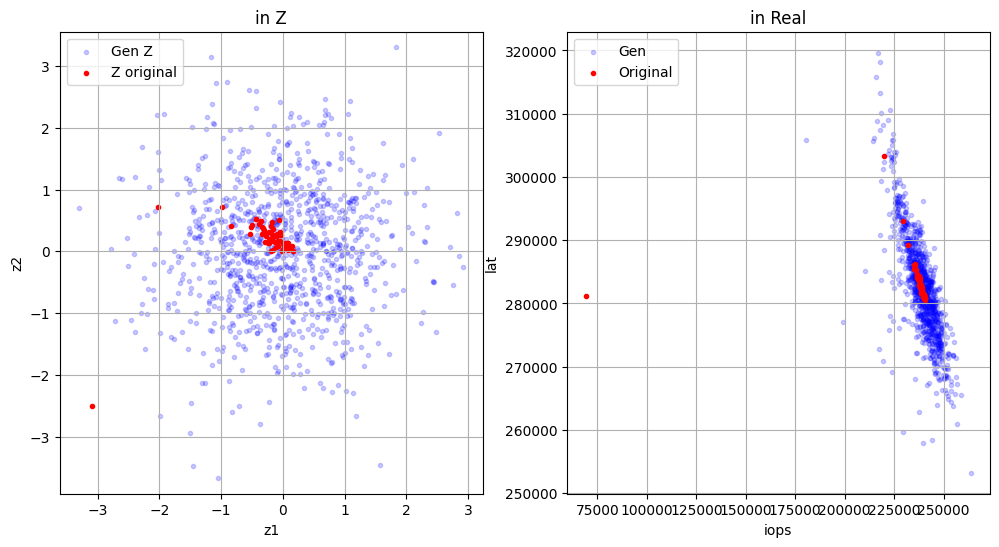

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[0], zgen_lat[0], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[0], ztotal_lat[0], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[0], gen_lat[0], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[0], total_lat[0], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[0])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[0])])
arr3 = np.array([[el] for el in np.array(zgen_iops[0])])
arr4 = np.array([[el] for el in np.array(zgen_lat[0])])

In [ ]:
print('In Z:')
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

In Z:
Frechet Distance         = 0.9242 +- 0.3109
Kolmogorov-Smirnov       = 0.4556 +- 0.0149
Cramer-von Mises         = 2.8821 +- 0.2411
Anderson-Darling         = 17.0289 +- 1.4449
ROC AUC                  = 0.5716 +- 0.0153
Kullback-Leibler KDE     = 0.3120 +- 0.0218
Jensen-Shannon KDE       = 0.0893 +- 0.0066
Maximum Mean Discrepancy = 0.1082 +- 0.0105


In [ ]:
# arr1 = np.array([[el] for el in np.array(total_iops[0])])
# arr2 = np.array([[el] for el in np.array(total_lat[0])])
# arr3 = np.array([[el] for el in np.array(gen_iops[0])])
# arr4 = np.array([[el] for el in np.array(gen_lat[0])])

In [ ]:
# print('In Real:')
# calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

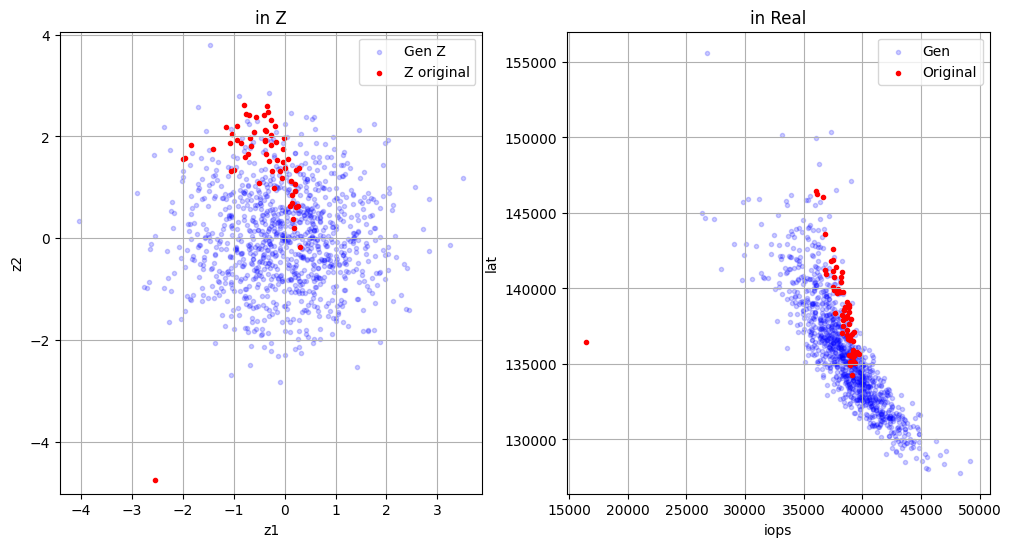

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[1], zgen_lat[1], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[1], ztotal_lat[1], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[1], gen_lat[1], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[1], total_lat[1], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[1])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[1])])
arr3 = np.array([[el] for el in np.array(zgen_iops[1])])
arr4 = np.array([[el] for el in np.array(zgen_lat[1])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 2.8358 +- 0.4269
Kolmogorov-Smirnov       = 0.5499 +- 0.0214
Cramer-von Mises         = 6.9072 +- 0.6569
Anderson-Darling         = 53.1386 +- 5.9249
ROC AUC                  = 0.7723 +- 0.0170
Kullback-Leibler KDE     = 0.8227 +- 0.0899
Jensen-Shannon KDE       = 0.1762 +- 0.0156
Maximum Mean Discrepancy = 0.4173 +- 0.0432


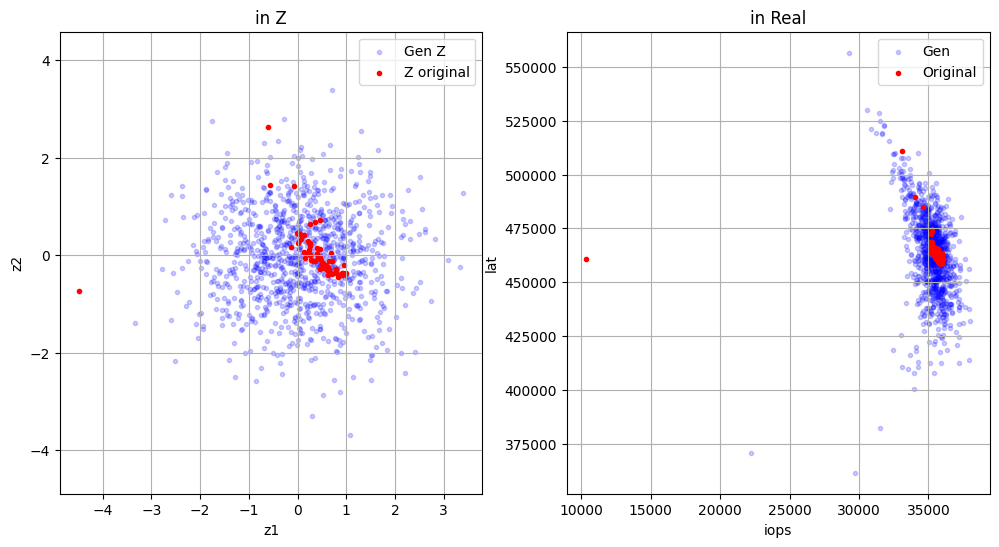

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[2], zgen_lat[2], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[2], ztotal_lat[2], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[2], gen_lat[2], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[2], total_lat[2], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[2])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[2])])
arr3 = np.array([[el] for el in np.array(zgen_iops[2])])
arr4 = np.array([[el] for el in np.array(zgen_lat[2])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 0.6803 +- 0.3685
Kolmogorov-Smirnov       = 0.3613 +- 0.0261
Cramer-von Mises         = 2.1004 +- 0.3677
Anderson-Darling         = 12.5674 +- 2.1334
ROC AUC                  = 0.5780 +- 0.0129
Kullback-Leibler KDE     = 0.2886 +- 0.0415
Jensen-Shannon KDE       = 0.0744 +- 0.0091
Maximum Mean Discrepancy = 0.1030 +- 0.0142


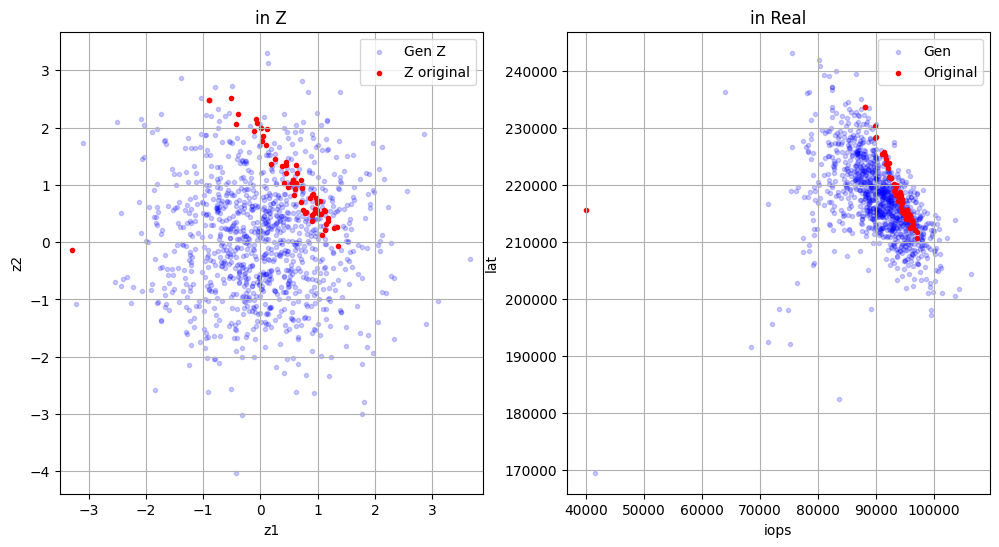

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[3], zgen_lat[3], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[3], ztotal_lat[3], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[3], gen_lat[3], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[3], total_lat[3], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[3])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[3])])
arr3 = np.array([[el] for el in np.array(zgen_iops[3])])
arr4 = np.array([[el] for el in np.array(zgen_lat[3])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 1.6846 +- 0.3710
Kolmogorov-Smirnov       = 0.4613 +- 0.0301
Cramer-von Mises         = 4.5055 +- 0.3911
Anderson-Darling         = 27.8508 +- 2.5241
ROC AUC                  = 0.7392 +- 0.0129
Kullback-Leibler KDE     = 0.4034 +- 0.0286
Jensen-Shannon KDE       = 0.1079 +- 0.0092
Maximum Mean Discrepancy = 0.2477 +- 0.0186


### RESULTS (TEST)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
ids = ['hse-09132022-203942-z36542-read', 'hse-09132022-192053-z87989-read',
       'hse-09132022-203942-z36542-write', 'hse-09132022-192053-z87989-write']
ztotal_iops = []
ztotal_lat = []
zgen_iops = []
zgen_lat = []

total_iops = []
total_lat = []
gen_iops = []
gen_lat = []
for i in range(len(ids)):
    y_test = torch.tensor(test[test['id'] == ids[i]][['iops', 'lat']].values)
    total_iops.append(y_test[:, 0])
    total_lat.append(y_test[:, 1])
    X_test = torch.tensor(test[test['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
    y_test_ss = scaler.transform(y_test)
    X_test_ss = stscaler.transform(X_test)
    y_tst = torch.tensor(y_test_ss, dtype=torch.float32)
    X_tst = torch.tensor(X_test_ss, dtype=torch.float32)
    # print(len(y_tst), len(X_tst))
    dataset = TensorDataset(y_tst, X_tst)
    results_iops = []
    results_lat = []
    for j, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        results_iops.append(y_data[0][0])
        results_lat.append(y_data[0][1])

    X_bigger = torch.tensor(list(test[test['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values) * 17)
    X_bigger_ss = stscaler.transform(X_bigger)
    X_bigger_tst = torch.tensor(X_bigger_ss, dtype=torch.float32)
    y_gen = model.sample(stscaler.transform(X_bigger.clone().detach()))
    y_gen = torch.tensor(y_gen, dtype=torch.float32)
    gen_iops.append(scaler.inverse_transform(y_gen)[:, 0])
    gen_lat.append(scaler.inverse_transform(y_gen)[:, 1])
    dataset = TensorDataset(y_gen, X_bigger_tst)
    genresults_iops = []
    genresults_lat = []
    for i, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        genresults_iops.append(y_data[0][0])
        genresults_lat.append(y_data[0][1])

    ztotal_iops.append(results_iops)
    ztotal_lat.append(results_lat)
    zgen_iops.append(genresults_iops)
    zgen_lat.append(genresults_lat)

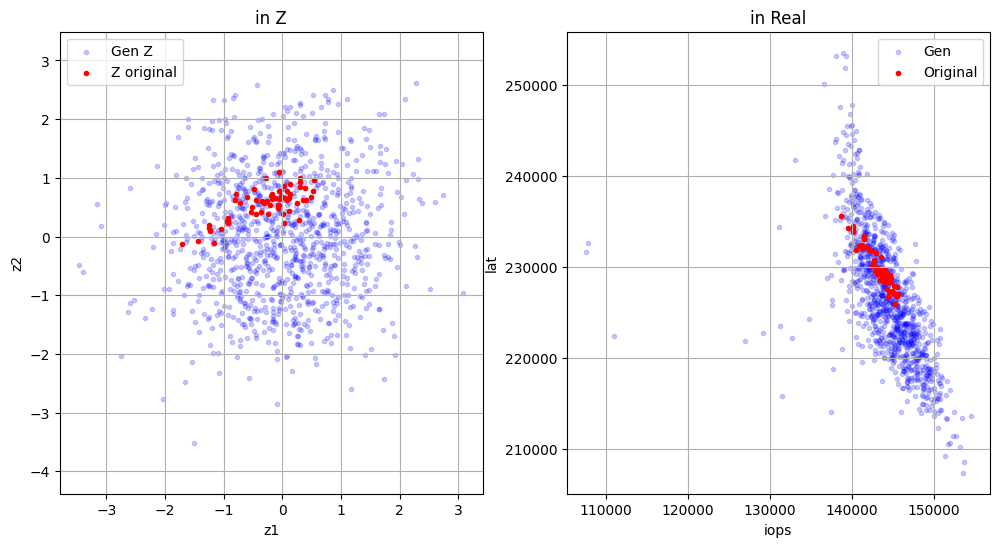

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[0], zgen_lat[0], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[0], ztotal_lat[0], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[0], gen_lat[0], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[0], total_lat[0], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[0])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[0])])
arr3 = np.array([[el] for el in np.array(zgen_iops[0])])
arr4 = np.array([[el] for el in np.array(zgen_lat[0])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 1.2536 +- 0.0810
Kolmogorov-Smirnov       = 0.4029 +- 0.0214
Cramer-von Mises         = 2.9726 +- 0.2515
Anderson-Darling         = 17.0094 +- 1.3766
ROC AUC                  = 0.6390 +- 0.0112
Kullback-Leibler KDE     = 0.3101 +- 0.0252
Jensen-Shannon KDE       = 0.0897 +- 0.0068
Maximum Mean Discrepancy = 0.1391 +- 0.0114


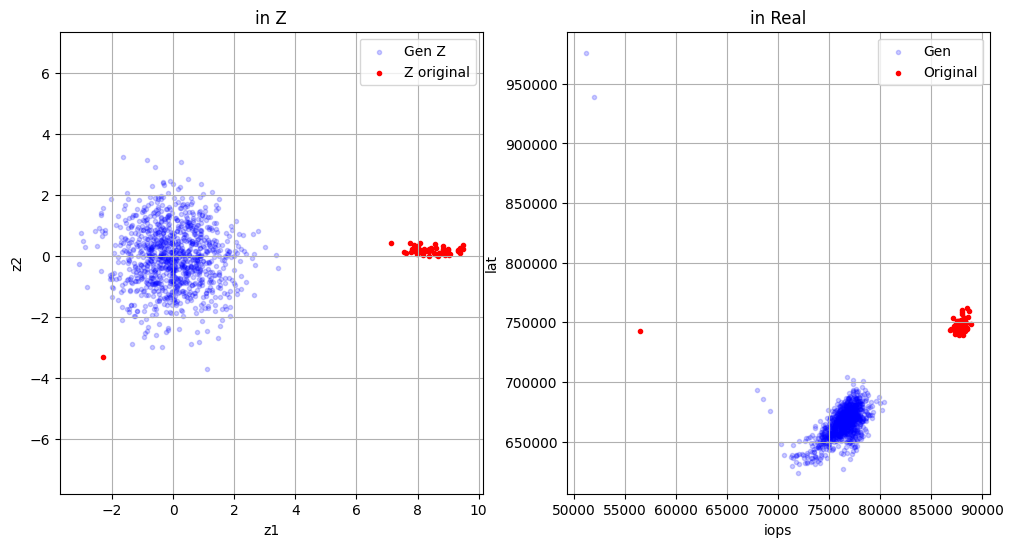

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[1], zgen_lat[1], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[1], ztotal_lat[1], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[1], gen_lat[1], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[1], total_lat[1], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[1])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[1])])
arr3 = np.array([[el] for el in np.array(zgen_iops[1])])
arr4 = np.array([[el] for el in np.array(zgen_lat[1])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 69.8398 +- 2.4458
Kolmogorov-Smirnov       = 0.7387 +- 0.0178
Cramer-von Mises         = 10.8517 +- 0.5413
Anderson-Darling         = 106.9382 +- 4.3537
ROC AUC                  = 0.7792 +- 0.0159
Kullback-Leibler KDE     = 6.6591 +- 0.1191
Jensen-Shannon KDE       = 0.3951 +- 0.0084
Maximum Mean Discrepancy = 1.5096 +- 0.0330


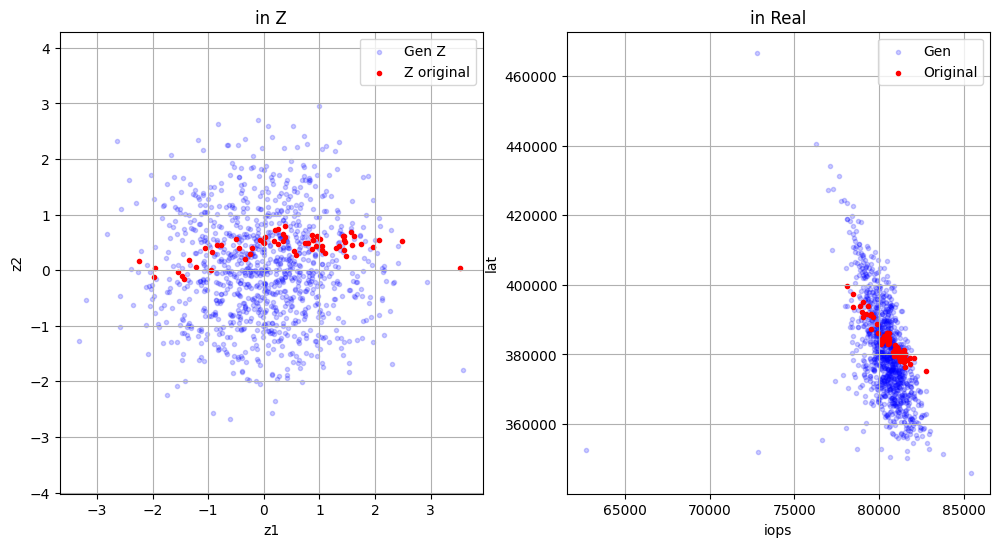

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[2], zgen_lat[2], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[2], ztotal_lat[2], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[2], gen_lat[2], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[2], total_lat[2], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[2])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[2])])
arr3 = np.array([[el] for el in np.array(zgen_iops[2])])
arr4 = np.array([[el] for el in np.array(zgen_lat[2])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 1.0123 +- 0.1627
Kolmogorov-Smirnov       = 0.3699 +- 0.0366
Cramer-von Mises         = 2.6727 +- 0.3868
Anderson-Darling         = 16.6362 +- 2.7892
ROC AUC                  = 0.6333 +- 0.0252
Kullback-Leibler KDE     = 0.2908 +- 0.0356
Jensen-Shannon KDE       = 0.0762 +- 0.0087
Maximum Mean Discrepancy = 0.0880 +- 0.0207


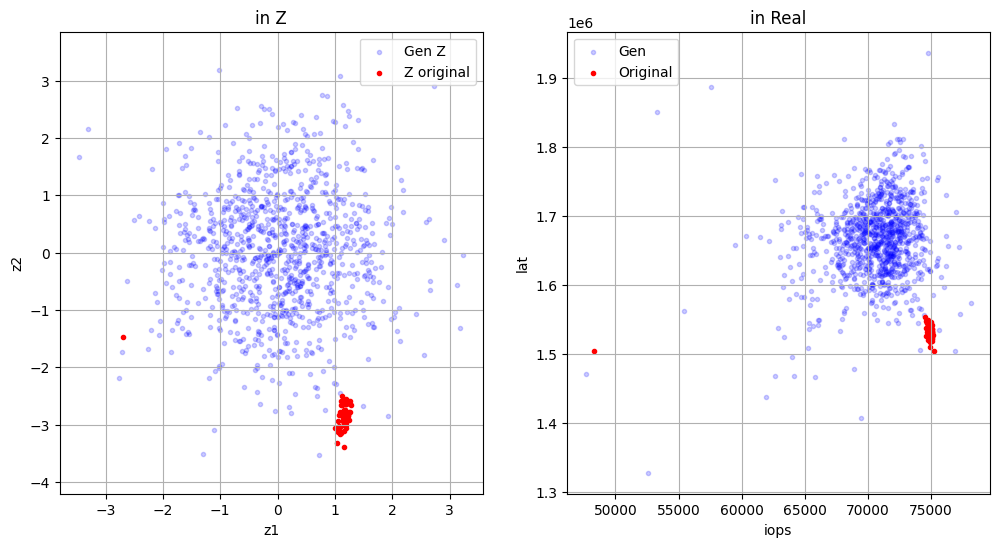

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[3], zgen_lat[3], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[3], ztotal_lat[3], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[3], gen_lat[3], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[3], total_lat[3], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[3])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[3])])
arr3 = np.array([[el] for el in np.array(zgen_iops[3])])
arr4 = np.array([[el] for el in np.array(zgen_lat[3])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 10.3203 +- 0.6265
Kolmogorov-Smirnov       = 0.9055 +- 0.0165
Cramer-von Mises         = 15.0893 +- 0.4605
Anderson-Darling         = 132.1911 +- 4.7181
ROC AUC                  = 0.9290 +- 0.0095
Kullback-Leibler KDE     = 2.3045 +- 0.1241
Jensen-Shannon KDE       = 0.4208 +- 0.0127
Maximum Mean Discrepancy = 1.0545 +- 0.0343


## Final experiments without outliers

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from probaforms.models import RealNVP
from probaforms import metrics

In [ ]:
train = new_train
scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
# y_test_ss = scaler.transform(test[['iops', 'lat']].values)
stscaler = StandardScaler()
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
# X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

model = RealNVP(lr=0.001, n_layers=6, n_epochs=120, batch_size=64, weight_decay=0.001, hidden=(100,100)) # 200 , activation='relu'

model.fit(y_tr_ss, X_tr_ss) # (target, condition)

(-10.0, 10.0)

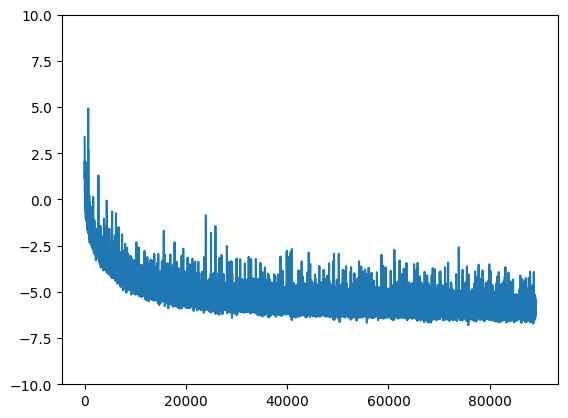

In [ ]:
plt.plot(model.loss_history)
plt.ylim(-10, 10)

In [ ]:
def calc_metrics(X, Y):
    mu, sigma = metrics.frechet_distance(X, Y)
    print(r"Frechet Distance         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.kolmogorov_smirnov_1d(X, Y)
    print(r"Kolmogorov-Smirnov       = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.cramer_von_mises_1d(X, Y)
    print(r"Cramer-von Mises         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.anderson_darling_1d(X, Y)
    print(r"Anderson-Darling         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.roc_auc_score_1d(X, Y)
    print(r"ROC AUC                  = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.kullback_leibler_1d_kde(X, Y)
    print(r"Kullback-Leibler KDE     = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.jensen_shannon_1d_kde(X, Y)
    print(r"Jensen-Shannon KDE       = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.maximum_mean_discrepancy(X, Y)
    print(r"Maximum Mean Discrepancy = %.4f +- %.4f" % (mu, sigma))

### RESULTS (TRAIN)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
a = torch.tensor(list(train[train['id'] == 'hse-09132022-234723-z24647-read'][['iops', 'lat']].values) * 17)
print(a)

tensor([[237495.0000, 282990.7100],
        [237975.0000, 283126.8900],
        [236411.0000, 284728.6400],
        ...,
        [237162.0000, 283795.3600],
        [238777.0000, 281577.5700],
        [239088.0000, 281640.3200]], dtype=torch.float64)


In [ ]:
ids = ['hse-09132022-234723-z24647-read', 'hse-09132022-155203-z5570-read',
       'hse-09132022-234723-z24647-write', 'hse-09132022-155203-z5570-write']
ztotal_iops = []
ztotal_lat = []
zgen_iops = []
zgen_lat = []

total_iops = []
total_lat = []
gen_iops = []
gen_lat = []
for i in range(len(ids)):
    y_train = torch.tensor(train[train['id'] == ids[i]][['iops', 'lat']].values)
    total_iops.append(y_train[:, 0])
    total_lat.append(y_train[:, 1])
    X_train = torch.tensor(train[train['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
    y_train_ss = scaler.transform(y_train)
    X_train_ss = stscaler.transform(X_train)
    y_tst = torch.tensor(y_train_ss, dtype=torch.float32)
    X_tst = torch.tensor(X_train_ss, dtype=torch.float32)
    # print(len(y_tst), len(X_tst))
    dataset = TensorDataset(y_tst, X_tst)
    results_iops = []
    results_lat = []
    for j, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        results_iops.append(y_data[0][0])
        results_lat.append(y_data[0][1])

    X_bigger = torch.tensor(list(train[train['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values) * 17)
    X_bigger_ss = stscaler.transform(X_bigger)
    X_bigger_tst = torch.tensor(X_bigger_ss, dtype=torch.float32)
    y_gen = model.sample(stscaler.transform(X_bigger.clone().detach()))
    y_gen = torch.tensor(y_gen, dtype=torch.float32)
    gen_iops.append(scaler.inverse_transform(y_gen)[:, 0])
    gen_lat.append(scaler.inverse_transform(y_gen)[:, 1])
    dataset = TensorDataset(y_gen, X_bigger_tst)
    genresults_iops = []
    genresults_lat = []
    for i, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        genresults_iops.append(y_data[0][0])
        genresults_lat.append(y_data[0][1])

    ztotal_iops.append(results_iops)
    ztotal_lat.append(results_lat)
    zgen_iops.append(genresults_iops)
    zgen_lat.append(genresults_lat)

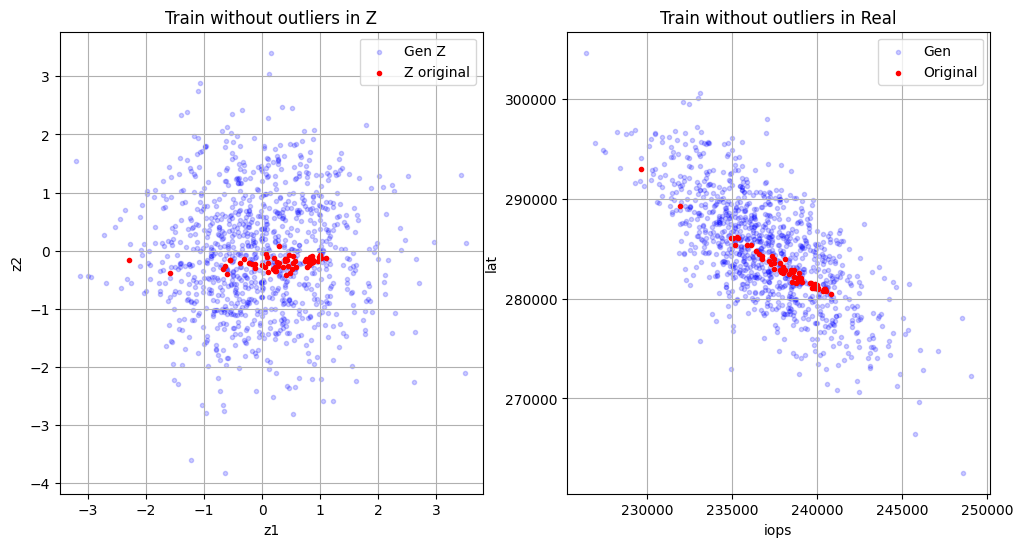

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[0], zgen_lat[0], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[0], ztotal_lat[0], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Train without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[0], gen_lat[0], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[0], total_lat[0], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Train without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[0])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[0])])
arr3 = np.array([[el] for el in np.array(zgen_iops[0])])
arr4 = np.array([[el] for el in np.array(zgen_lat[0])])

In [ ]:
print('In Z:')
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

In Z:
Frechet Distance         = 1.1714 +- 0.1501
Kolmogorov-Smirnov       = 0.3963 +- 0.0256
Cramer-von Mises         = 2.7986 +- 0.3053
Anderson-Darling         = 16.3504 +- 1.9815
ROC AUC                  = 0.5869 +- 0.0157
Kullback-Leibler KDE     = 0.2996 +- 0.0273
Jensen-Shannon KDE       = 0.0859 +- 0.0080
Maximum Mean Discrepancy = 0.1069 +- 0.0160


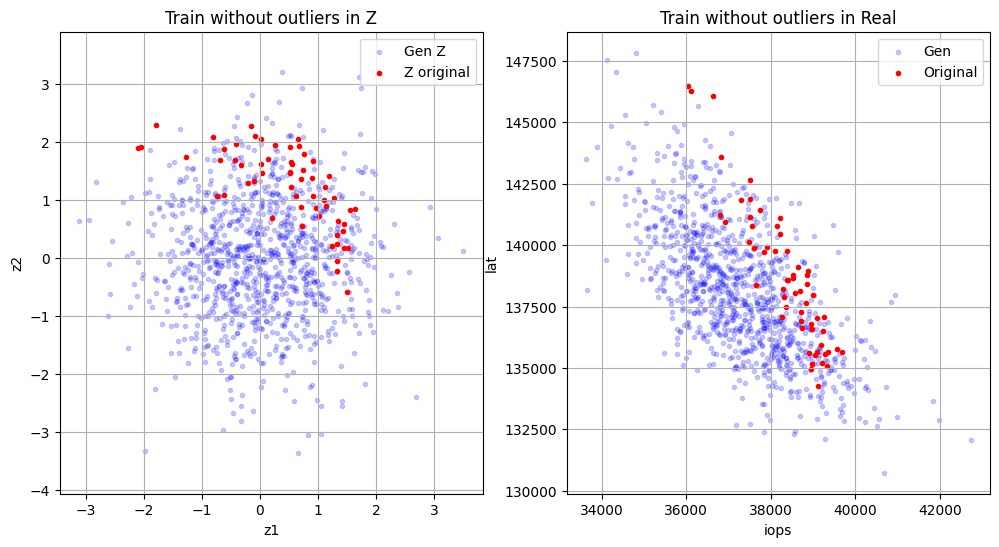

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[1], zgen_lat[1], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[1], ztotal_lat[1], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Train without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[1], gen_lat[1], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[1], total_lat[1], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Train without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[1])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[1])])
arr3 = np.array([[el] for el in np.array(zgen_iops[1])])
arr4 = np.array([[el] for el in np.array(zgen_lat[1])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 2.1434 +- 0.1981
Kolmogorov-Smirnov       = 0.4572 +- 0.0333
Cramer-von Mises         = 5.1657 +- 0.4896
Anderson-Darling         = 35.6952 +- 4.0790
ROC AUC                  = 0.7500 +- 0.0161
Kullback-Leibler KDE     = 0.4852 +- 0.0490
Jensen-Shannon KDE       = 0.1155 +- 0.0099
Maximum Mean Discrepancy = 0.2850 +- 0.0266


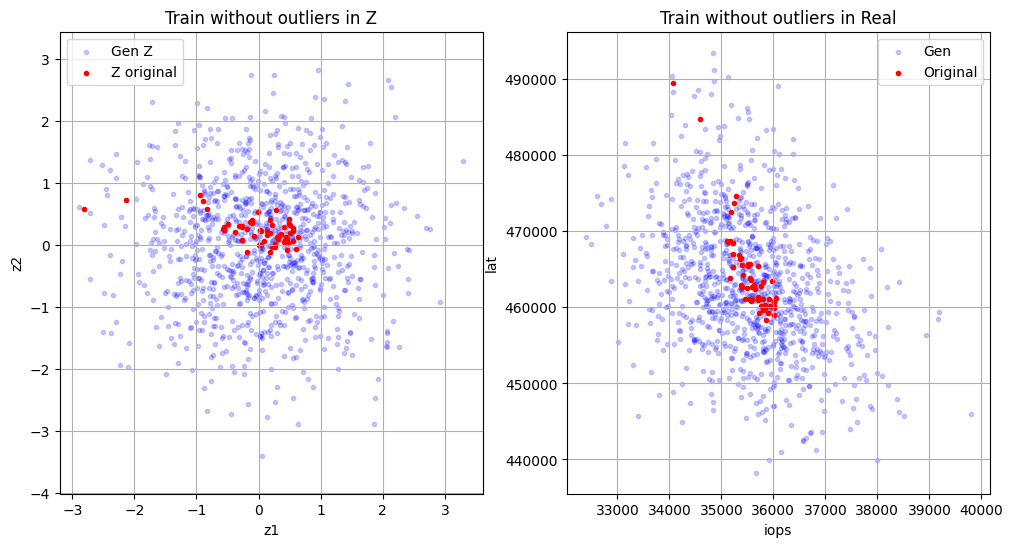

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[2], zgen_lat[2], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[2], ztotal_lat[2], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Train without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[2], gen_lat[2], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[2], total_lat[2], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Train without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[2])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[2])])
arr3 = np.array([[el] for el in np.array(zgen_iops[2])])
arr4 = np.array([[el] for el in np.array(zgen_lat[2])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 0.9278 +- 0.1084
Kolmogorov-Smirnov       = 0.3705 +- 0.0114
Cramer-von Mises         = 1.9804 +- 0.2044
Anderson-Darling         = 12.1260 +- 1.2000
ROC AUC                  = 0.5474 +- 0.0118
Kullback-Leibler KDE     = 0.2490 +- 0.0205
Jensen-Shannon KDE       = 0.0711 +- 0.0053
Maximum Mean Discrepancy = 0.0851 +- 0.0103


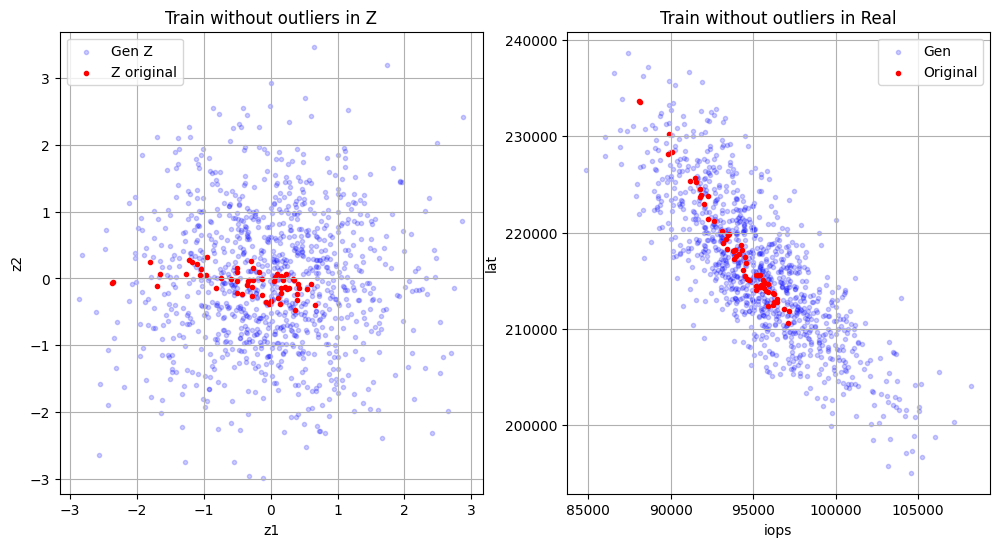

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[3], zgen_lat[3], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[3], ztotal_lat[3], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Train without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[3], gen_lat[3], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[3], total_lat[3], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Train without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[3])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[3])])
arr3 = np.array([[el] for el in np.array(zgen_iops[3])])
arr4 = np.array([[el] for el in np.array(zgen_lat[3])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 0.9772 +- 0.0833
Kolmogorov-Smirnov       = 0.3396 +- 0.0182
Cramer-von Mises         = 1.9584 +- 0.1510
Anderson-Darling         = 12.3128 +- 1.0752
ROC AUC                  = 0.5558 +- 0.0119
Kullback-Leibler KDE     = 0.2544 +- 0.0174
Jensen-Shannon KDE       = 0.0726 +- 0.0055
Maximum Mean Discrepancy = 0.0770 +- 0.0082


### RESULTS (TEST)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
test = new_test

In [ ]:
ids = ['hse-09132022-203942-z36542-read', 'hse-09132022-192053-z87989-read',
       'hse-09132022-203942-z36542-write', 'hse-09132022-192053-z87989-write']
ztotal_iops = []
ztotal_lat = []
zgen_iops = []
zgen_lat = []

total_iops = []
total_lat = []
gen_iops = []
gen_lat = []
for i in range(len(ids)):
    y_test = torch.tensor(test[test['id'] == ids[i]][['iops', 'lat']].values)
    total_iops.append(y_test[:, 0])
    total_lat.append(y_test[:, 1])
    X_test = torch.tensor(test[test['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
    y_test_ss = scaler.transform(y_test)
    X_test_ss = stscaler.transform(X_test)
    y_tst = torch.tensor(y_test_ss, dtype=torch.float32)
    X_tst = torch.tensor(X_test_ss, dtype=torch.float32)
    # print(len(y_tst), len(X_tst))
    dataset = TensorDataset(y_tst, X_tst)
    results_iops = []
    results_lat = []
    for j, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        results_iops.append(y_data[0][0])
        results_lat.append(y_data[0][1])

    X_bigger = torch.tensor(list(test[test['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values) * 17)
    X_bigger_ss = stscaler.transform(X_bigger)
    X_bigger_tst = torch.tensor(X_bigger_ss, dtype=torch.float32)
    y_gen = model.sample(stscaler.transform(X_bigger.clone().detach()))
    y_gen = torch.tensor(y_gen, dtype=torch.float32)
    gen_iops.append(scaler.inverse_transform(y_gen)[:, 0])
    gen_lat.append(scaler.inverse_transform(y_gen)[:, 1])
    dataset = TensorDataset(y_gen, X_bigger_tst)
    genresults_iops = []
    genresults_lat = []
    for i, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        genresults_iops.append(y_data[0][0])
        genresults_lat.append(y_data[0][1])

    ztotal_iops.append(results_iops)
    ztotal_lat.append(results_lat)
    zgen_iops.append(genresults_iops)
    zgen_lat.append(genresults_lat)

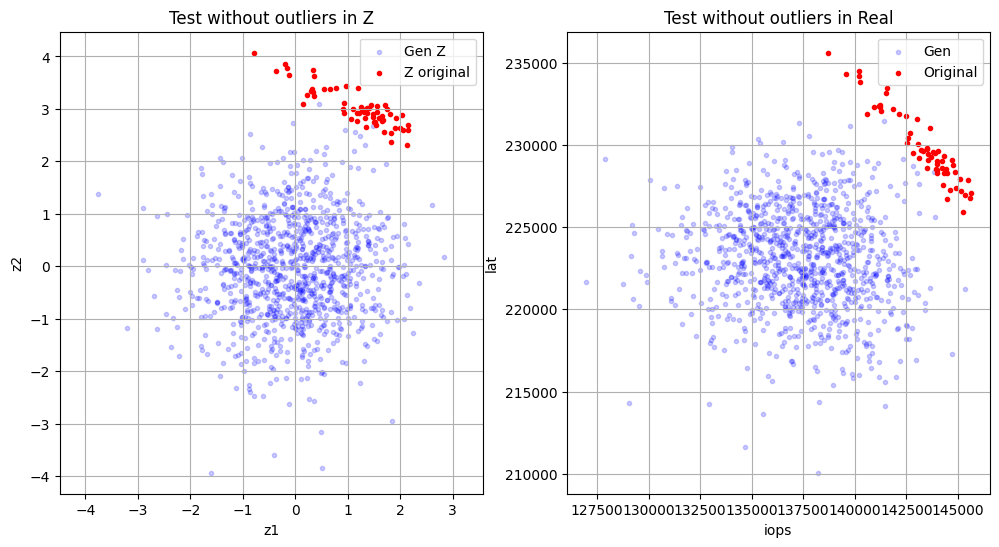

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[0], zgen_lat[0], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[0], ztotal_lat[0], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Test without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[0], gen_lat[0], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[0], total_lat[0], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Test without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[0])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[0])])
arr3 = np.array([[el] for el in np.array(zgen_iops[0])])
arr4 = np.array([[el] for el in np.array(zgen_lat[0])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 11.6936 +- 0.2691
Kolmogorov-Smirnov       = 0.7892 +- 0.0285
Cramer-von Mises         = 13.6339 +- 0.6021
Anderson-Darling         = 130.2344 +- 4.8437
ROC AUC                  = 0.9215 +- 0.0107
Kullback-Leibler KDE     = 2.9802 +- 0.3077
Jensen-Shannon KDE       = 0.4018 +- 0.0131
Maximum Mean Discrepancy = 1.0917 +- 0.0229


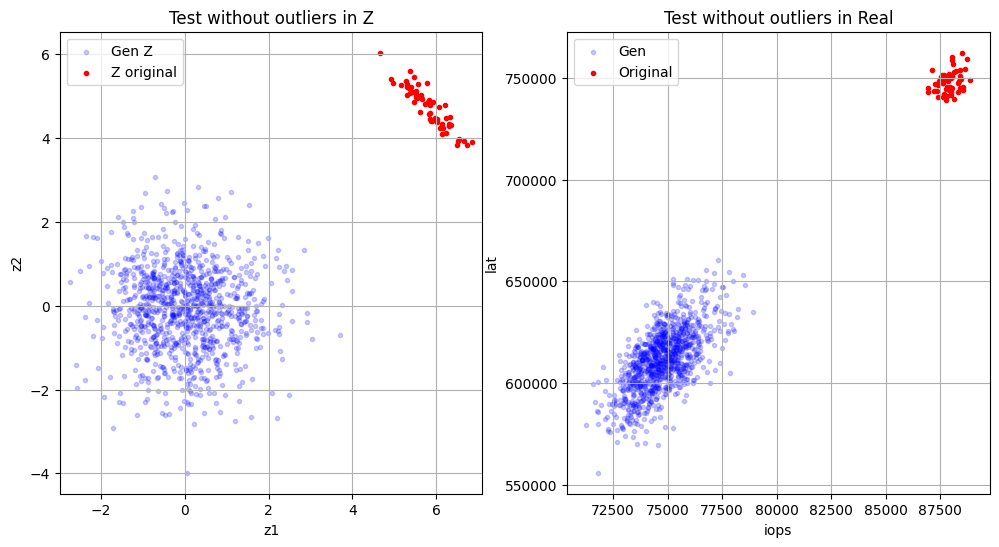

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[1], zgen_lat[1], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[1], ztotal_lat[1], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Test without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[1], gen_lat[1], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[1], total_lat[1], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Test without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[1])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[1])])
arr3 = np.array([[el] for el in np.array(zgen_iops[1])])
arr4 = np.array([[el] for el in np.array(zgen_lat[1])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 57.8562 +- 0.5378
Kolmogorov-Smirnov       = 1.0000 +- 0.0000
Cramer-von Mises         = 18.5796 +- 0.0004
Anderson-Darling         = 197.5728 +- 0.0709
ROC AUC                  = 1.0000 +- 0.0000
Kullback-Leibler KDE     = 12.5169 +- 0.1302
Jensen-Shannon KDE       = 0.6898 +- 0.0008
Maximum Mean Discrepancy = 1.4977 +- 0.0153


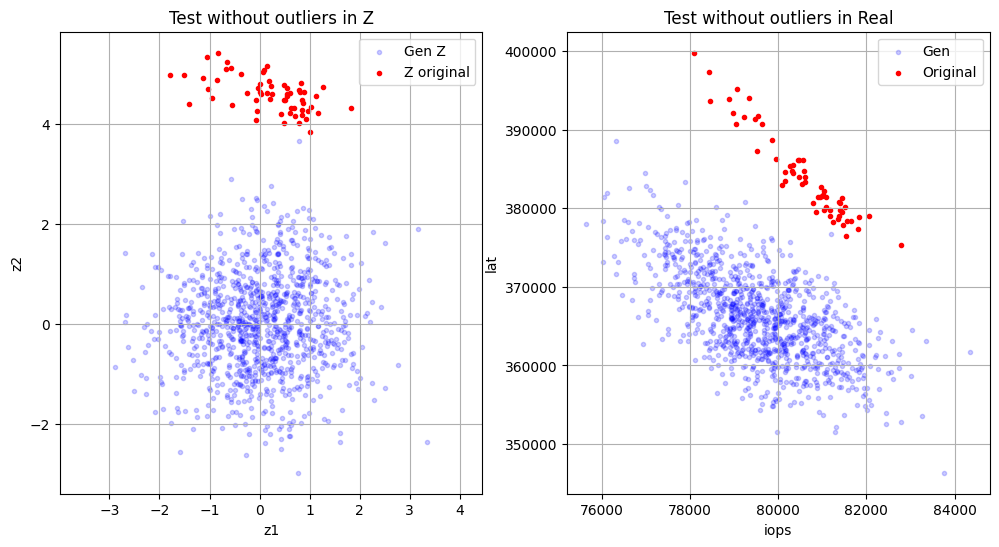

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[2], zgen_lat[2], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[2], ztotal_lat[2], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Test without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[2], gen_lat[2], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[2], total_lat[2], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Test without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[2])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[2])])
arr3 = np.array([[el] for el in np.array(zgen_iops[2])])
arr4 = np.array([[el] for el in np.array(zgen_lat[2])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 21.5210 +- 0.4880
Kolmogorov-Smirnov       = 0.6184 +- 0.0287
Cramer-von Mises         = 9.8246 +- 0.2326
Anderson-Darling         = 102.0288 +- 1.2767
ROC AUC                  = 0.7841 +- 0.0170
Kullback-Leibler KDE     = 5.5400 +- 0.6418
Jensen-Shannon KDE       = 0.3510 +- 0.0032
Maximum Mean Discrepancy = 1.3268 +- 0.0211


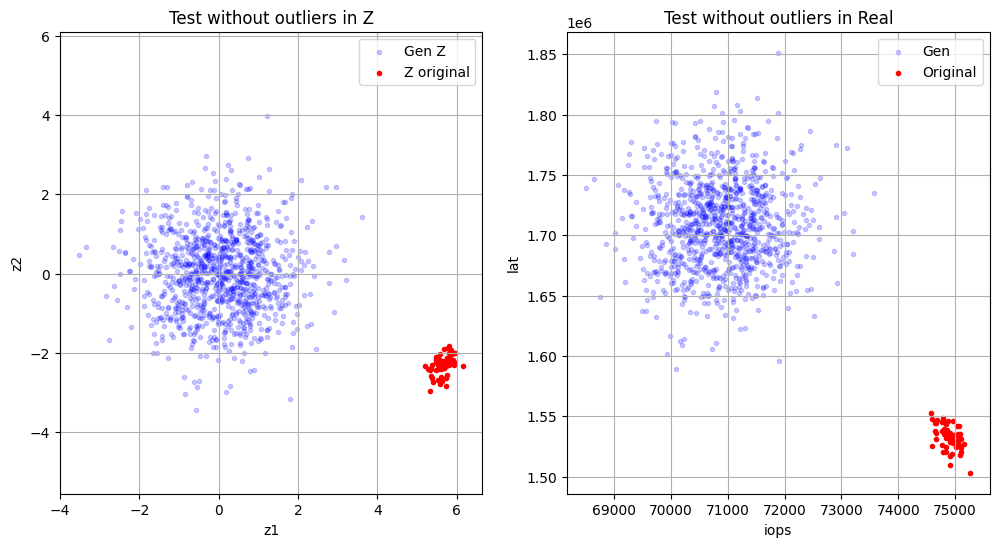

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[3], zgen_lat[3], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[3], ztotal_lat[3], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Test without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[3], gen_lat[3], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[3], total_lat[3], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Test without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[3])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[3])])
arr3 = np.array([[el] for el in np.array(zgen_iops[3])])
arr4 = np.array([[el] for el in np.array(zgen_lat[3])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 38.1764 +- 0.4702
Kolmogorov-Smirnov       = 0.9876 +- 0.0025
Cramer-von Mises         = 18.1798 +- 0.0998
Anderson-Darling         = 183.4345 +- 2.6906
ROC AUC                  = 0.9940 +- 0.0015
Kullback-Leibler KDE     = 8.1034 +- 0.0850
Jensen-Shannon KDE       = 0.6080 +- 0.0050
Maximum Mean Discrepancy = 1.5675 +- 0.0051


'hse-09132022-180712-z63065-read'

посмотреть метрики, сравнить пред обучение и это. relu: lr поменьше!

## Final experiments without outliers (relu)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from probaforms.models import RealNVP
from probaforms import metrics

https://github.com/pytorch/pytorch/issues/15131

https://github.com/pytorch/pytorch/issues/59228

lr = 0.0001 падает

0.00001 что-то не так с лоссом



In [ ]:
train = new_train
scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
# y_test_ss = scaler.transform(test[['iops', 'lat']].values)
stscaler = StandardScaler()
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
# X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

model = RealNVP(lr=0.00001, n_layers=6, n_epochs=120, batch_size=64, weight_decay=0.001, hidden=(100,100), activation='relu') # 200 , activation='relu'

model.fit(y_tr_ss, X_tr_ss) # (target, condition)

(-10.0, 10.0)

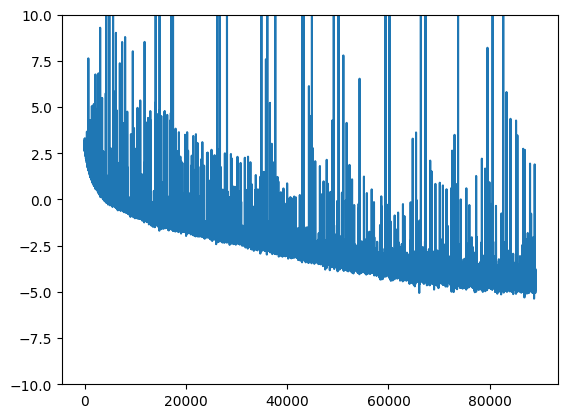

In [ ]:
plt.plot(model.loss_history)
plt.ylim(-10, 10)

In [ ]:
def calc_metrics(X, Y):
    mu, sigma = metrics.frechet_distance(X, Y)
    print(r"Frechet Distance         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.kolmogorov_smirnov_1d(X, Y)
    print(r"Kolmogorov-Smirnov       = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.cramer_von_mises_1d(X, Y)
    print(r"Cramer-von Mises         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.anderson_darling_1d(X, Y)
    print(r"Anderson-Darling         = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.roc_auc_score_1d(X, Y)
    print(r"ROC AUC                  = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.kullback_leibler_1d_kde(X, Y)
    print(r"Kullback-Leibler KDE     = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.jensen_shannon_1d_kde(X, Y)
    print(r"Jensen-Shannon KDE       = %.4f +- %.4f" % (mu, sigma))
    mu, sigma = metrics.maximum_mean_discrepancy(X, Y)
    print(r"Maximum Mean Discrepancy = %.4f +- %.4f" % (mu, sigma))

### RESULTS (TRAIN)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
a = torch.tensor(list(train[train['id'] == 'hse-09132022-234723-z24647-read'][['iops', 'lat']].values) * 17)
print(a)

tensor([[237495.0000, 282990.7100],
        [237975.0000, 283126.8900],
        [236411.0000, 284728.6400],
        ...,
        [237162.0000, 283795.3600],
        [238777.0000, 281577.5700],
        [239088.0000, 281640.3200]], dtype=torch.float64)


In [ ]:
ids = ['hse-09132022-234723-z24647-read', 'hse-09132022-155203-z5570-read',
       'hse-09132022-234723-z24647-write', 'hse-09132022-155203-z5570-write']
ztotal_iops = []
ztotal_lat = []
zgen_iops = []
zgen_lat = []

total_iops = []
total_lat = []
gen_iops = []
gen_lat = []
for i in range(len(ids)):
    y_train = torch.tensor(train[train['id'] == ids[i]][['iops', 'lat']].values)
    total_iops.append(y_train[:, 0])
    total_lat.append(y_train[:, 1])
    X_train = torch.tensor(train[train['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
    y_train_ss = scaler.transform(y_train)
    X_train_ss = stscaler.transform(X_train)
    y_tst = torch.tensor(y_train_ss, dtype=torch.float32)
    X_tst = torch.tensor(X_train_ss, dtype=torch.float32)
    # print(len(y_tst), len(X_tst))
    dataset = TensorDataset(y_tst, X_tst)
    results_iops = []
    results_lat = []
    for j, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        results_iops.append(y_data[0][0])
        results_lat.append(y_data[0][1])

    X_bigger = torch.tensor(list(train[train['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values) * 17)
    X_bigger_ss = stscaler.transform(X_bigger)
    X_bigger_tst = torch.tensor(X_bigger_ss, dtype=torch.float32)
    y_gen = model.sample(stscaler.transform(X_bigger.clone().detach()))
    y_gen = torch.tensor(y_gen, dtype=torch.float32)
    gen_iops.append(scaler.inverse_transform(y_gen)[:, 0])
    gen_lat.append(scaler.inverse_transform(y_gen)[:, 1])
    dataset = TensorDataset(y_gen, X_bigger_tst)
    genresults_iops = []
    genresults_lat = []
    for i, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        genresults_iops.append(y_data[0][0])
        genresults_lat.append(y_data[0][1])

    ztotal_iops.append(results_iops)
    ztotal_lat.append(results_lat)
    zgen_iops.append(genresults_iops)
    zgen_lat.append(genresults_lat)

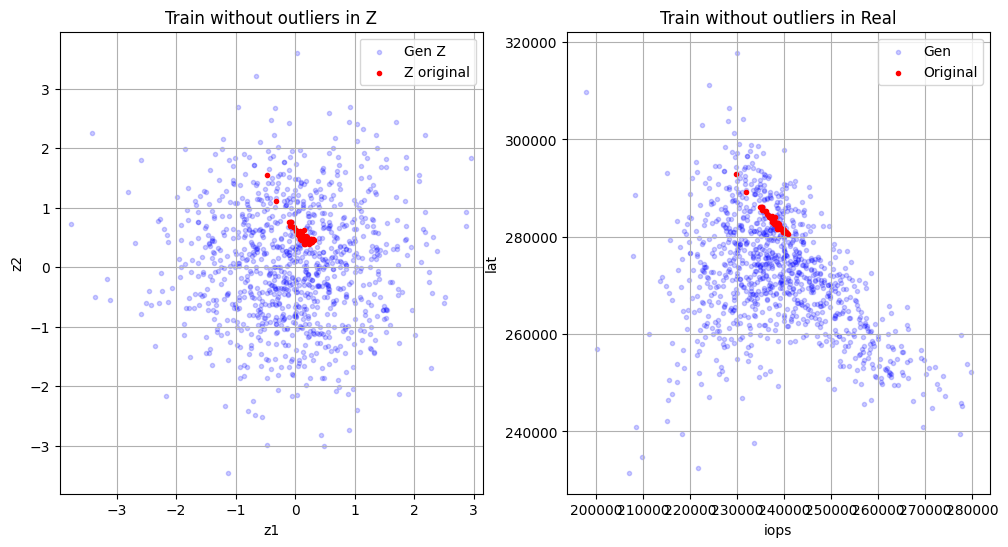

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[0], zgen_lat[0], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[0], ztotal_lat[0], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Train without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[0], gen_lat[0], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[0], total_lat[0], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Train without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[0])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[0])])
arr3 = np.array([[el] for el in np.array(zgen_iops[0])])
arr4 = np.array([[el] for el in np.array(zgen_lat[0])])

In [ ]:
print('In Z:')
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

In Z:
Frechet Distance         = 1.7832 +- 0.1105
Kolmogorov-Smirnov       = 0.5395 +- 0.0176
Cramer-von Mises         = 4.3492 +- 0.1934
Anderson-Darling         = 25.8022 +- 1.2319
ROC AUC                  = 0.6305 +- 0.0102
Kullback-Leibler KDE     = 0.4025 +- 0.0189
Jensen-Shannon KDE       = 0.1160 +- 0.0061
Maximum Mean Discrepancy = 0.1690 +- 0.0066


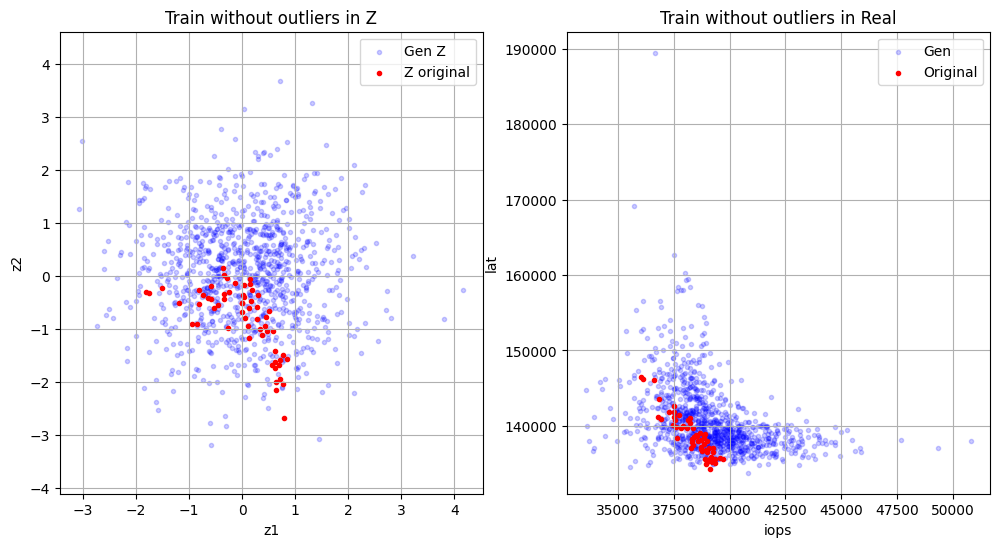

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[1], zgen_lat[1], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[1], ztotal_lat[1], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Train without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[1], gen_lat[1], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[1], total_lat[1], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Train without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[1])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[1])])
arr3 = np.array([[el] for el in np.array(zgen_iops[1])])
arr4 = np.array([[el] for el in np.array(zgen_lat[1])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 1.1957 +- 0.1351
Kolmogorov-Smirnov       = 0.3730 +- 0.0159
Cramer-von Mises         = 3.0326 +- 0.3666
Anderson-Darling         = 16.9513 +- 1.9225
ROC AUC                  = 0.6434 +- 0.0113
Kullback-Leibler KDE     = 0.2687 +- 0.0293
Jensen-Shannon KDE       = 0.0762 +- 0.0066
Maximum Mean Discrepancy = 0.1418 +- 0.0177


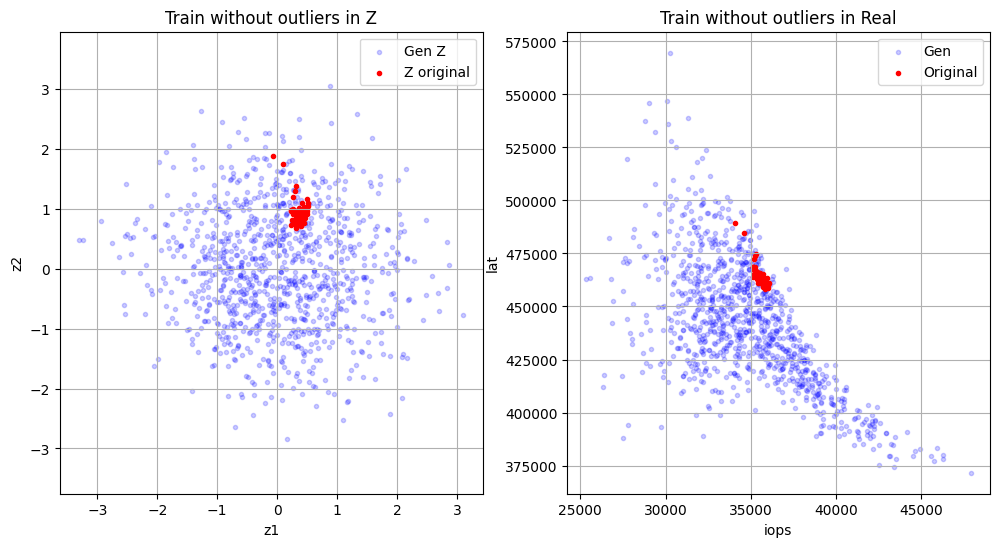

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[2], zgen_lat[2], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[2], ztotal_lat[2], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Train without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[2], gen_lat[2], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[2], total_lat[2], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Train without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[2])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[2])])
arr3 = np.array([[el] for el in np.array(zgen_iops[2])])
arr4 = np.array([[el] for el in np.array(zgen_lat[2])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 2.4728 +- 0.1007
Kolmogorov-Smirnov       = 0.6583 +- 0.0138
Cramer-von Mises         = 6.8386 +- 0.2515
Anderson-Darling         = 40.1048 +- 1.7479
ROC AUC                  = 0.7327 +- 0.0095
Kullback-Leibler KDE     = 0.5930 +- 0.0253
Jensen-Shannon KDE       = 0.1677 +- 0.0061
Maximum Mean Discrepancy = 0.2884 +- 0.0147


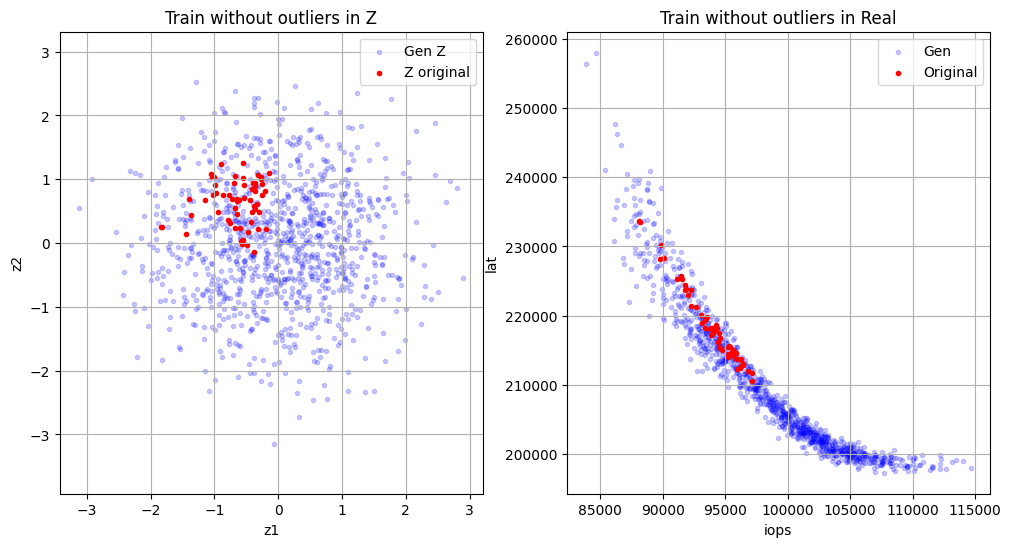

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[3], zgen_lat[3], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[3], ztotal_lat[3], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Train without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[3], gen_lat[3], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[3], total_lat[3], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Train without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[3])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[3])])
arr3 = np.array([[el] for el in np.array(zgen_iops[3])])
arr4 = np.array([[el] for el in np.array(zgen_lat[3])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 1.6101 +- 0.1064
Kolmogorov-Smirnov       = 0.5348 +- 0.0172
Cramer-von Mises         = 4.8903 +- 0.3883
Anderson-Darling         = 28.0744 +- 2.6044
ROC AUC                  = 0.7285 +- 0.0114
Kullback-Leibler KDE     = 0.4318 +- 0.0278
Jensen-Shannon KDE       = 0.1237 +- 0.0078
Maximum Mean Discrepancy = 0.2261 +- 0.0183


### RESULTS (TEST)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
test = new_test

In [ ]:
ids = ['hse-09132022-203942-z36542-read', 'hse-09132022-192053-z87989-read',
       'hse-09132022-203942-z36542-write', 'hse-09132022-192053-z87989-write']
ztotal_iops = []
ztotal_lat = []
zgen_iops = []
zgen_lat = []

total_iops = []
total_lat = []
gen_iops = []
gen_lat = []
for i in range(len(ids)):
    y_test = torch.tensor(test[test['id'] == ids[i]][['iops', 'lat']].values)
    total_iops.append(y_test[:, 0])
    total_lat.append(y_test[:, 1])
    X_test = torch.tensor(test[test['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
    y_test_ss = scaler.transform(y_test)
    X_test_ss = stscaler.transform(X_test)
    y_tst = torch.tensor(y_test_ss, dtype=torch.float32)
    X_tst = torch.tensor(X_test_ss, dtype=torch.float32)
    # print(len(y_tst), len(X_tst))
    dataset = TensorDataset(y_tst, X_tst)
    results_iops = []
    results_lat = []
    for j, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        results_iops.append(y_data[0][0])
        results_lat.append(y_data[0][1])

    X_bigger = torch.tensor(list(test[test['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values) * 17)
    X_bigger_ss = stscaler.transform(X_bigger)
    X_bigger_tst = torch.tensor(X_bigger_ss, dtype=torch.float32)
    y_gen = model.sample(stscaler.transform(X_bigger.clone().detach()))
    y_gen = torch.tensor(y_gen, dtype=torch.float32)
    gen_iops.append(scaler.inverse_transform(y_gen)[:, 0])
    gen_lat.append(scaler.inverse_transform(y_gen)[:, 1])
    dataset = TensorDataset(y_gen, X_bigger_tst)
    genresults_iops = []
    genresults_lat = []
    for i, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        genresults_iops.append(y_data[0][0])
        genresults_lat.append(y_data[0][1])

    ztotal_iops.append(results_iops)
    ztotal_lat.append(results_lat)
    zgen_iops.append(genresults_iops)
    zgen_lat.append(genresults_lat)

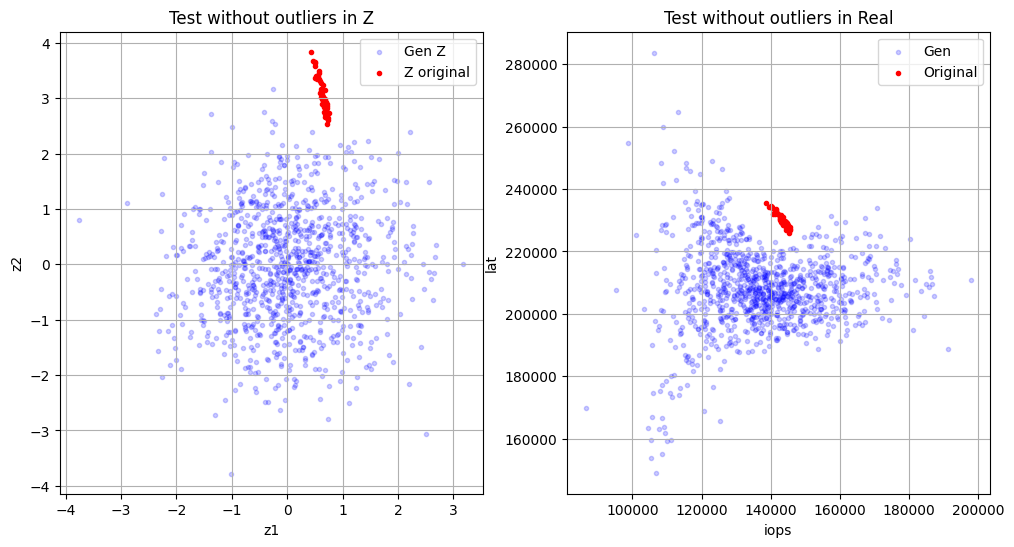

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[0], zgen_lat[0], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[0], ztotal_lat[0], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Test without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[0], gen_lat[0], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[0], total_lat[0], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Test without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[0])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[0])])
arr3 = np.array([[el] for el in np.array(zgen_iops[0])])
arr4 = np.array([[el] for el in np.array(zgen_lat[0])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 11.3729 +- 0.3087
Kolmogorov-Smirnov       = 0.8429 +- 0.0091
Cramer-von Mises         = 13.2384 +- 0.2133
Anderson-Darling         = 121.5152 +- 1.6042
ROC AUC                  = 0.8751 +- 0.0062
Kullback-Leibler KDE     = 2.8502 +- 0.3137
Jensen-Shannon KDE       = 0.3963 +- 0.0052
Maximum Mean Discrepancy = 1.0891 +- 0.0233


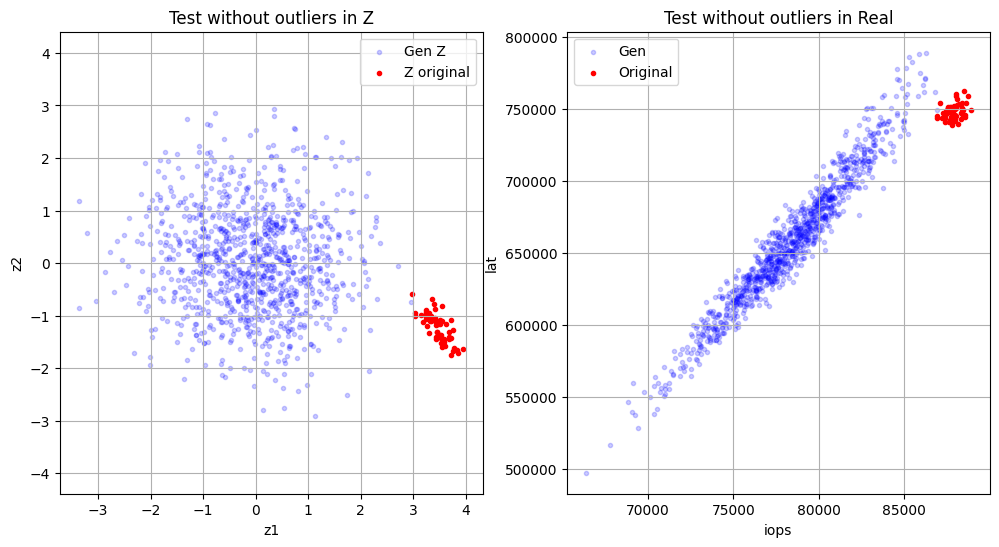

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[1], zgen_lat[1], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[1], ztotal_lat[1], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Test without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[1], gen_lat[1], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[1], total_lat[1], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Test without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[1])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[1])])
arr3 = np.array([[el] for el in np.array(zgen_iops[1])])
arr4 = np.array([[el] for el in np.array(zgen_lat[1])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 15.4475 +- 0.3401
Kolmogorov-Smirnov       = 0.8865 +- 0.0143
Cramer-von Mises         = 15.2169 +- 0.2963
Anderson-Darling         = 137.8260 +- 2.8669
ROC AUC                  = 0.9470 +- 0.0052
Kullback-Leibler KDE     = 4.5642 +- 0.6063
Jensen-Shannon KDE       = 0.4655 +- 0.0076
Maximum Mean Discrepancy = 1.2884 +- 0.0191


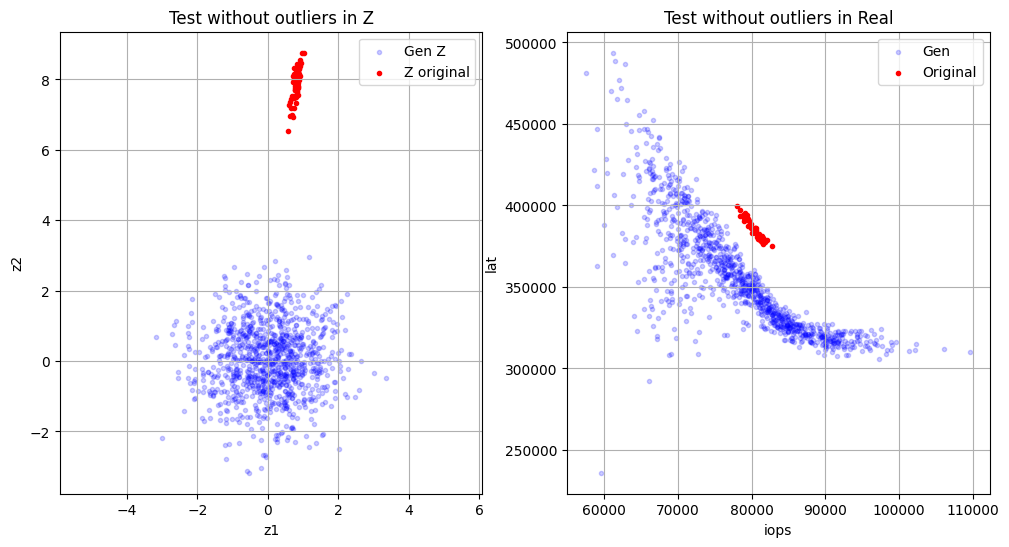

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[2], zgen_lat[2], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[2], ztotal_lat[2], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Test without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[2], gen_lat[2], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[2], total_lat[2], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Test without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[2])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[2])])
arr3 = np.array([[el] for el in np.array(zgen_iops[2])])
arr4 = np.array([[el] for el in np.array(zgen_lat[2])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 62.8722 +- 1.0848
Kolmogorov-Smirnov       = 0.8658 +- 0.0082
Cramer-von Mises         = 13.9334 +- 0.2093
Anderson-Darling         = 126.8568 +- 1.4788
ROC AUC                  = 0.8978 +- 0.0061
Kullback-Leibler KDE     = 6.9227 +- 0.0328
Jensen-Shannon KDE       = 0.4376 +- 0.0037
Maximum Mean Discrepancy = 1.5632 +- 0.0113


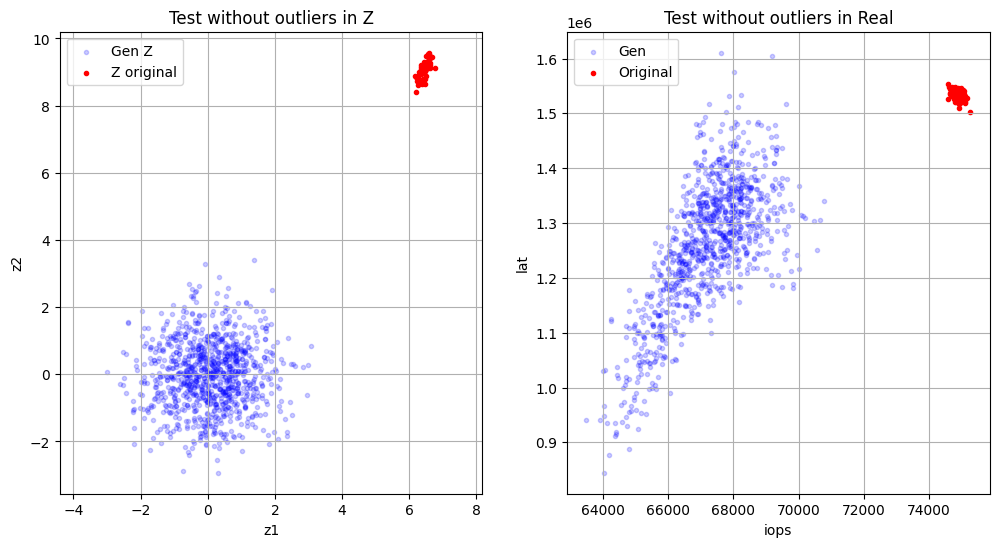

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(zgen_iops[3], zgen_lat[3], marker='.', label='Gen Z', color='blue', linewidth=1, alpha=0.2)
ax1.scatter(ztotal_iops[3], ztotal_lat[3], marker='.', label='Z original', color='red', linewidth=1)
ax1.set_title("Test without outliers in Z")
ax1.axis('equal')
ax1.set(xlabel='z1', ylabel='z2')
ax1.grid()
ax1.legend()

ax2.scatter(gen_iops[3], gen_lat[3], marker='.', label='Gen', color='blue', linewidth=1, alpha=0.2)
ax2.scatter(total_iops[3], total_lat[3], marker='.', label='Original', color='red', linewidth=1)
ax2.set_title("Test without outliers in Real")
# ax2.axis('equal')
ax2.set(xlabel='iops', ylabel='lat')
ax2.grid()
ax2.legend()

In [ ]:
arr1 = np.array([[el] for el in np.array(ztotal_iops[3])])
arr2 = np.array([[el] for el in np.array(ztotal_lat[3])])
arr3 = np.array([[el] for el in np.array(zgen_iops[3])])
arr4 = np.array([[el] for el in np.array(zgen_lat[3])])

In [ ]:
calc_metrics(np.hstack((arr1, arr2)), np.hstack((arr3, arr4)))

Frechet Distance         = 124.9930 +- 0.9733
Kolmogorov-Smirnov       = 1.0000 +- 0.0000
Cramer-von Mises         = 18.5795 +- 0.0004
Anderson-Darling         = 197.5742 +- 0.0763
ROC AUC                  = 1.0000 +- 0.0000
Kullback-Leibler KDE     = 13.5444 +- 0.0289
Jensen-Shannon KDE       = 0.6931 +- 0.0000
Maximum Mean Discrepancy = 1.5962 +- 0.0039


'hse-09132022-180712-z63065-read'

## more

> Julia N:
1. Nlayers = 4,6,8
2. Hidden (100, 100)
3. Подписи сделай норм пж!

> Julia N:
loss

> Julia N:
Loss history вывести

> Julia N:
Weight_decay = 1/1000

> Julia N:
Побольше итераций


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from probaforms.models import RealNVP
from probaforms import metrics

In [ ]:
train = new_train.copy()
scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
# y_test_ss = scaler.transform(test[['iops', 'lat']].values)
stscaler = StandardScaler()
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
# X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

model = RealNVP(lr=0.001, n_layers=6, n_epochs=50, batch_size=64, weight_decay=0.001, hidden=(100,100), activation='relu') # 200 , activation='relu' weight_decay=0.001
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

In [ ]:
print(model.loss_history)

[tensor(3.6163), tensor(3.2669), tensor(2.9173), tensor(2.8492), tensor(2.8659), tensor(3.0366), tensor(2.8253), tensor(2.5392), tensor(2.1611), tensor(2.2155), tensor(2.6282), tensor(1.9193), tensor(1.9916), tensor(1.9385), tensor(1.7763), tensor(1.8848), tensor(1.5302), tensor(1.8251), tensor(1.5416), tensor(1.6361), tensor(1.3705), tensor(1.8626), tensor(1.1071), tensor(1.1742), tensor(1.2226), tensor(1.2787), tensor(1.4093), tensor(1.7683), tensor(1.2214), tensor(0.9961), tensor(1.0303), tensor(1.3452), tensor(0.6138), tensor(0.8862), tensor(0.6626), tensor(1.0763), tensor(1.1199), tensor(0.7599), tensor(0.4930), tensor(0.5366), tensor(0.5587), tensor(0.6683), tensor(0.2299), tensor(0.6652), tensor(0.0792), tensor(0.4291), tensor(0.7345), tensor(1.2567), tensor(0.7840), tensor(0.3161), tensor(0.3331), tensor(0.6264), tensor(0.6142), tensor(0.2934), tensor(0.7041), tensor(0.2525), tensor(0.3001), tensor(0.4539), tensor(0.3056), tensor(0.3759), tensor(0.6094), tensor(0.4138), tensor(

(-10.0, 10.0)

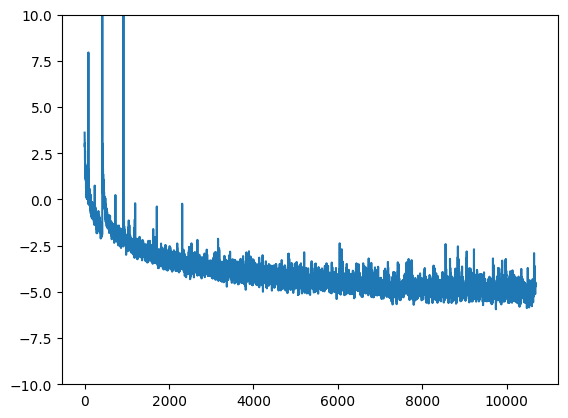

In [ ]:
plt.plot(model.loss_history)
plt.ylim(-10, 10)

## aaa

это код когда я просто проверяла модельку, запускать не нада

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_new[0], y_new[1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

In [ ]:
results1 = []
results2 = []
results3 = []
numb = 10 # 10

for i in range(numb):
  print(i)
  ids = pd.unique(train[['id']]. values.ravel())
  id1 = np.array([np.random.sample() for k in range(len(ids))])
  ar = []
  for j in range(len(ids)):
    if id1[j] <= 0.7:
      ar.append(ids[j])
  train = train.loc[train['id'].isin(ar)]
  scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
  y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
  y_test_ss = scaler.transform(test[['iops', 'lat']].values)
  stscaler = StandardScaler()
  X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  # model
  model = RealNVP(lr=0.001, n_layers=24, n_epochs=200, batch_size=64) # 200
  model.fit(y_tr_ss, X_tr_ss) # (target, condition)
  # samples 1
  y_test = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)
  X_test = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  y_gen = model.sample(stscaler.transform(X_test.clone().detach()))
  y_gen = scaler.inverse_transform(y_gen)
  if i == 0:
    results1.append(y_test)
  results1.append(y_gen)
  # samples 2
  y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-203942-z36542'][['iops', 'lat']].values)
  X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-203942-z36542'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  y_gen_2 = model.sample(stscaler.transform(X_test_2.clone().detach()))
  y_gen_2 = scaler.inverse_transform(y_gen_2)
  if i == 0:
    results2.append(y_test_2)
  results2.append(y_gen_2)
  # samples 3
  y_test_3 = torch.tensor(test[test['id'] == 'hse-09132022-192053-z87989'][['iops', 'lat']].values)
  X_test_3 = torch.tensor(test[test['id'] == 'hse-09132022-192053-z87989'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  y_gen_3 = model.sample(stscaler.transform(X_test_3.clone().detach()))
  y_gen_3 = scaler.inverse_transform(y_gen_3)
  if i == 0:
    results3.append(y_test_3)
  results3.append(y_gen_3)

0


<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


1


<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


2


<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


3


<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
colors = np.array(["blue","red","green","yellow","pink","black","orange","purple","brown","cyan","magenta"])

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(results1[0][:, 0], results1[0][:, 1], marker='.', label='Observations', color=colors[0], linewidth=1)
for i in range(1, numb+1):
  plt.scatter(results1[i][:, 0], results1[i][:, 1], marker='.', label='Generated with NF', color=colors[i], linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(results2[0][:, 0], results2[0][:, 1], marker='.', label='Observations', color=colors[0], linewidth=1)
for i in range(1, numb+1):
  plt.scatter(results2[i][:, 0], results2[i][:, 1], marker='.', label='Generated with NF', color=colors[i], linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(results3[0][:, 0], results3[0][:, 1], marker='.', label='Observations', color=colors[0], linewidth=1)
for i in range(1, numb+1):
  plt.scatter(results3[i][:, 0], results3[i][:, 1], marker='.', label='Generated with NF', color=colors[i], linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()